# Denoising

Philippe Massouf
Diego Torres

## 1. Spectrum density estimation

In [1]:
import numpy as np
import pandas as pd

from scipy.io.wavfile import read
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.signal import welch, convolve2d

import matplotlib.pyplot as plt

In [2]:
sr, noise1 = read('noise1.wav')
sr, noise2 = read('noise2.wav')
sr, noise3 = read('noise3.wav')

In [8]:
def plot_figures(noise):
    # Take the fourier transform of the signal
    periodogram  = fft(noise)
    # Get the frequencies corresponding to the signal using the sampling rate
    freq = fftfreq(noise.shape[0], 1/sr)
    # Use the Welch method to find a good estimate of the power spectral density
    freqs, power = welch(noise, fs=sr, nperseg=1024)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    
    # Noise plot
    ax1.plot(noise)
    ax1.set_xlabel('Time (frame)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Time domain')

    # Power spectrum plot
    ax2.plot(freq[:len(freq)//2], 20*np.log(np.abs(periodogram[:len(periodogram)//2])))
    ax2.set_xscale('log')
    ax2.set_ylabel('Power (dB)')

    # Power spectrum with Welch method
    ax3.plot(freqs, 10*np.log(power))
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_xscale('log')
    ax3.set_ylabel('Power (dB)')

    return freqs, power


For the first noise we can confidently say that it's a white noise, especially considering the power spectrum obtained using Welch method. Indeed this is a great example of why using a more advanced method than periodogram is useful, since the power spectrum with that method resulted in a very noisy signal which is not clearly identified as the spectrum of white noise. 

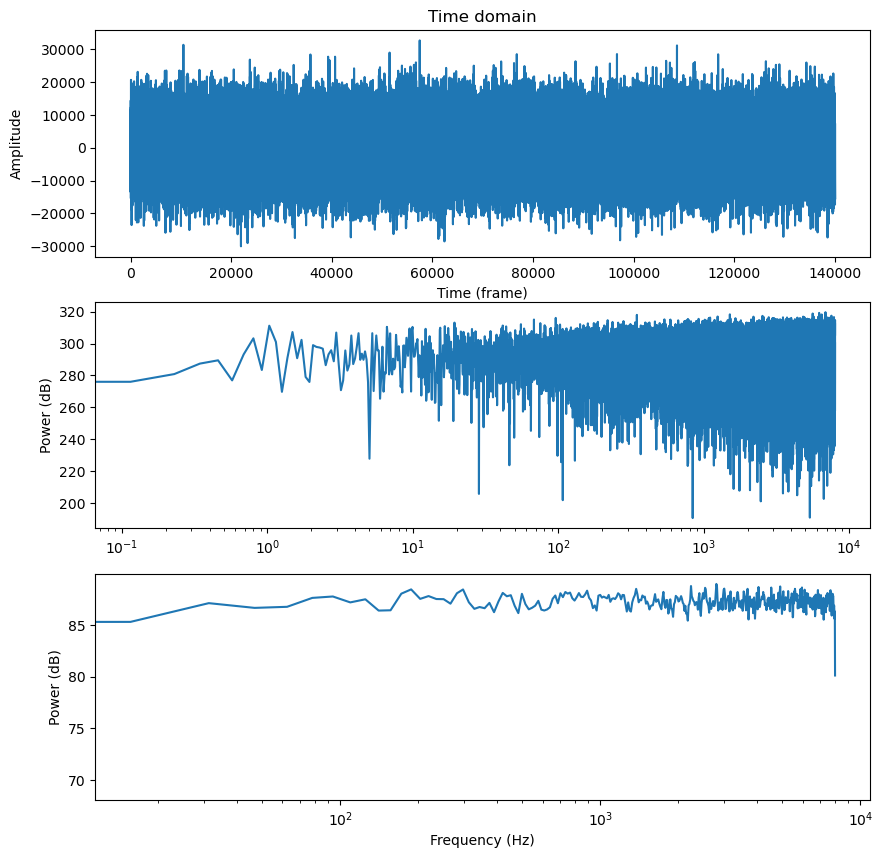

In [12]:
freqs, noise1_power = plot_figures(noise1)

The second noise is also relatively easy to identify, it is pink noise. Pink noise is characterised by a linear relation between the power spectrum and the frequency in *logarithmic scale*, which is what we see in both plots. For this noise we also note that the periodogram does a very good job estimating the spectrum, probably because this is a very prototypical example of a pink noise.

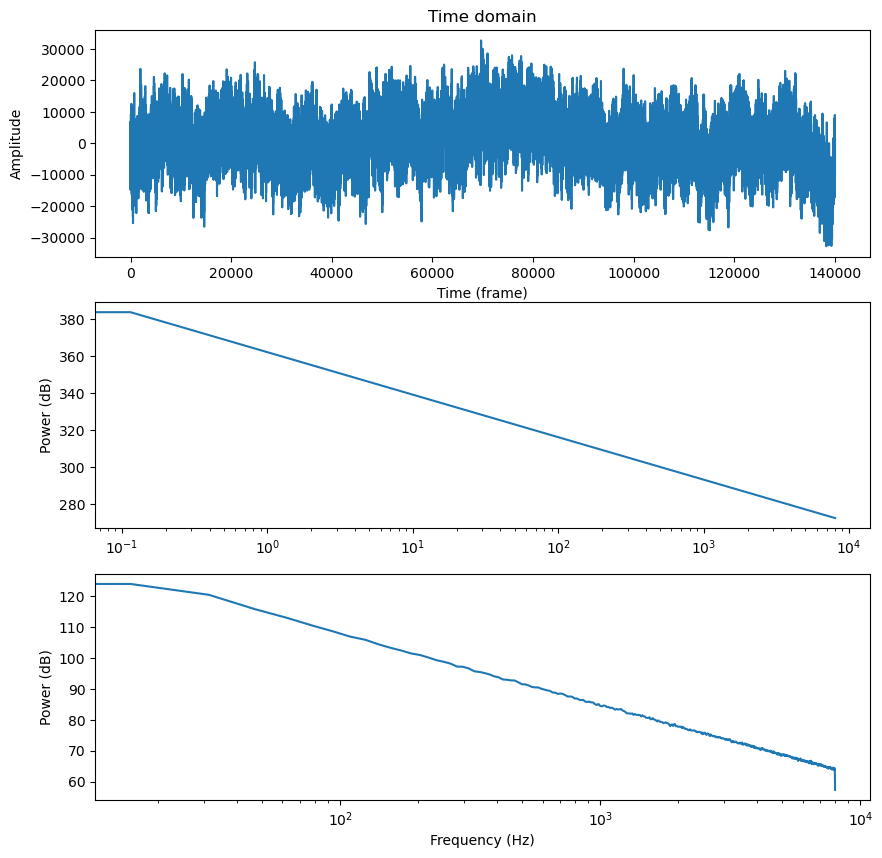

In [13]:
freqs, noise2_power = plot_figures(noise2)

The third noise was more tricky to guess its color, but we are pretty confident that it's red, or Brownian noise. It is described by a power spectrum that behaves as a $1/f^2$ function of the frequency.

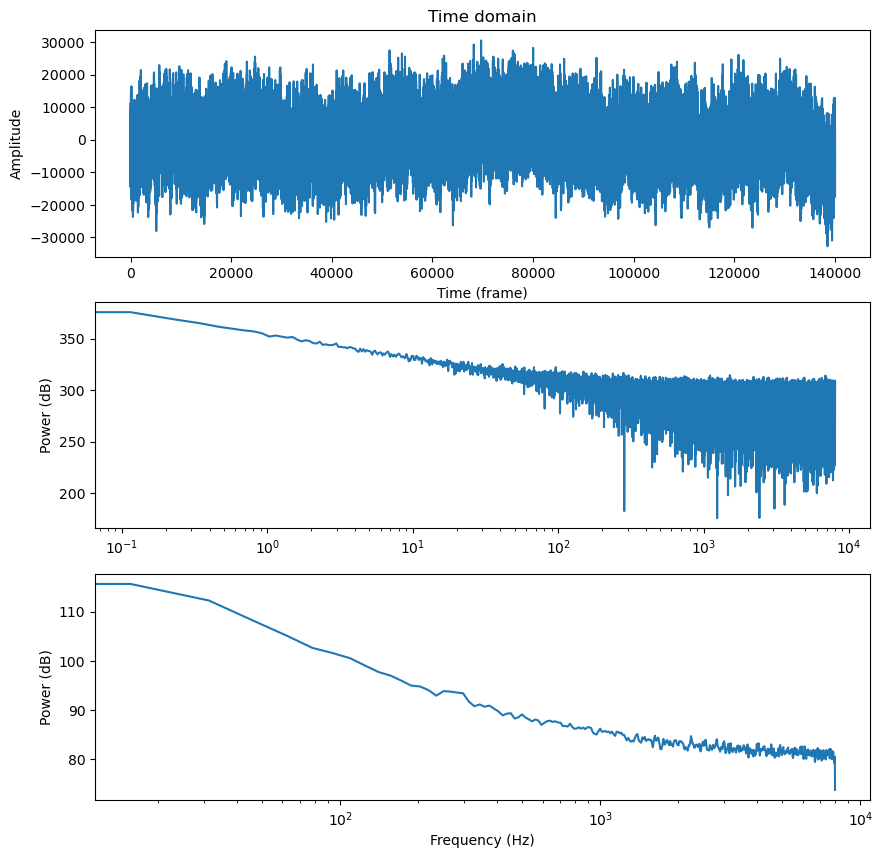

In [14]:
freqs, noise3_power = plot_figures(noise3)

If we plot the spectra of the three noises combined we get a clear picture of their behaviour. In linear scale the white noise spectrum stays constant, naturally. On the other hand, the pink and red noise express more clearly the $1/f$ and $1/f^2$ relation respectively. 

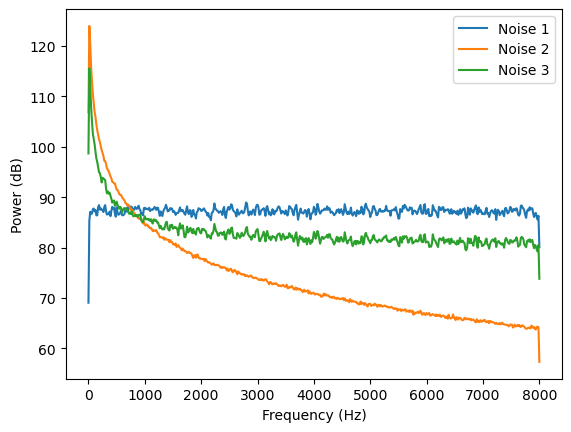

In [37]:
plt.plot(freqs, 10*np.log(noise1_power), label='Noise 1')
plt.plot(freqs, 10*np.log(noise2_power), label='Noise 2')
plt.plot(freqs, 10*np.log(noise3_power), label='Noise 3')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.legend()
plt.show()

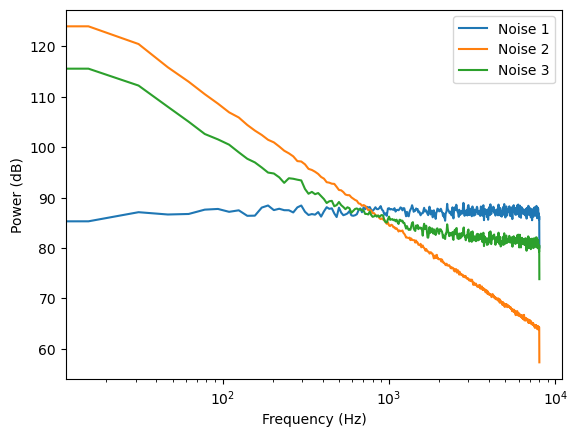

In [38]:
plt.plot(freqs, 10*np.log(noise1_power), label='Noise 1')
plt.plot(freqs, 10*np.log(noise2_power), label='Noise 2')
plt.plot(freqs, 10*np.log(noise3_power), label='Noise 3')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.legend()
plt.show()

# 2. Denoising images

## Noisy images generation

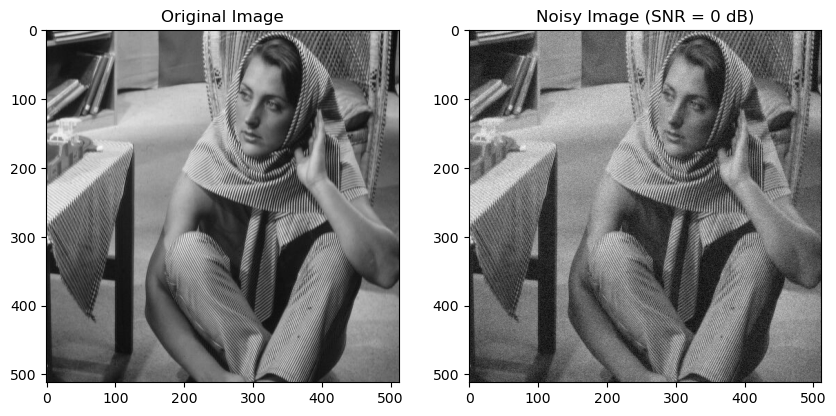

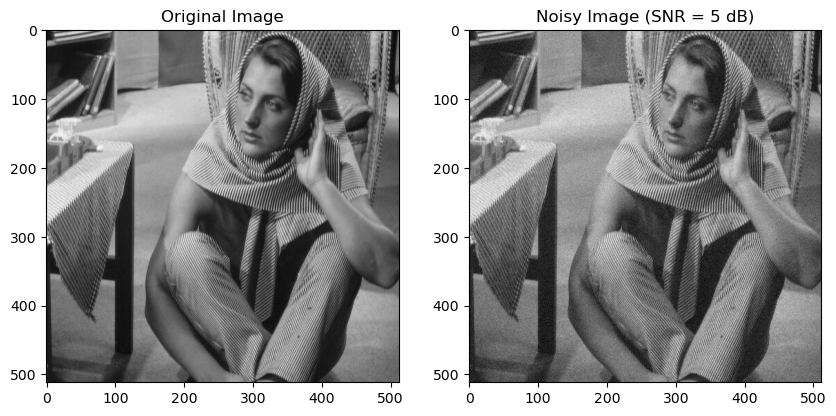

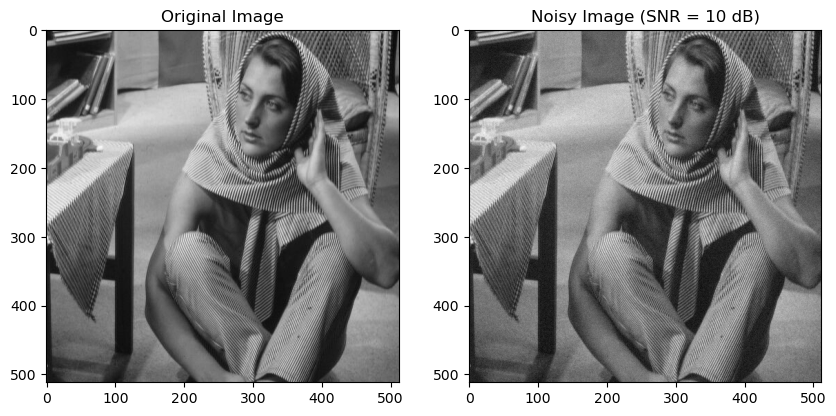

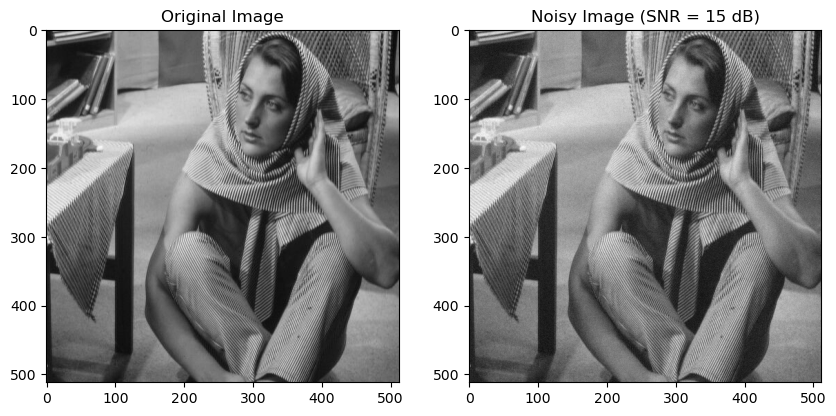

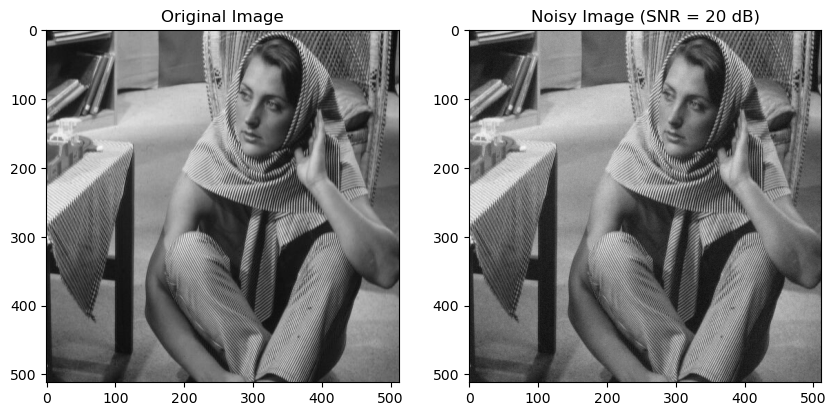

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft, fftfreq, fftshift, ifft, fft2, ifft2

#We simulate a noisy version of the image with various SNR (0dB, 5 dB, 10 dB, 15 dB, 20 dB), using a Gaussian white noise


# Reading the image
img_pil = Image.open('barbara.jpg').convert("L")  # Convert to grayscale
img = np.array(img_pil)  # Convert PIL Image to NumPy array

def generate_noise(img, snr):
    N= img.shape[0]*img.shape[1]
    noise_var = (np.sum(img**2)/N)* np.exp(-snr / 10)

    noise = np.random.normal(0, np.sqrt(noise_var), img.shape) #we use a gaussian noise
    return noise

def add_noise(img, snr):
    return img + generate_noise(img, snr)

def plot_noisy_image(img, snr):

    # Plotting the image and the noisy image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    # Adding noise to the image
    noisy_img = add_noise(img, snr)
    # Cliping the values to be in range [0, 255]
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Noisy Image (SNR = ' + str(snr) + ' dB)')
    plt.show()


plot_noisy_image(img, 0)
plot_noisy_image(img, 5)
plot_noisy_image(img, 10)
plot_noisy_image(img, 15)
plot_noisy_image(img, 20)



## Denoising the image using the Wiener filter

In the previous example the difference between the original image and the denoised one was not that obvious. A low SNR makes the image appear more noisy but it is diffcult to see. In this example we will use a more noisy image and we will compare the results of the Wiener filter denoising with the original image.

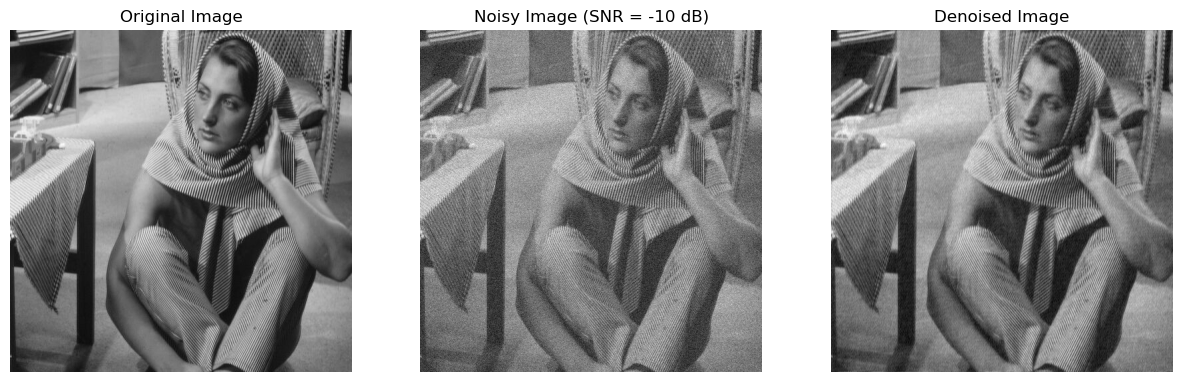

In [4]:
def wiener_filter(noisy_img, original_img, noise_img):
    
    noisy_img_fft = fft2(noisy_img)
    original_img_fft = fft2(original_img)
    noise_img_fft = fft2(noise_img)
    
    #Estimating the power spectral density of the original image and the noise
    P_x = np.abs(original_img_fft) ** 2
    P_n = np.abs(noise_img_fft) ** 2
    #Computing the Wiener filter
    H = P_x/(P_x + P_n)
    #Multiplying it with the Fourier Transform of the noisy image
    denoised_img_fft = H * noisy_img_fft
    
    # Getting the denoised image
    denoised_img = np.abs(ifft2(denoised_img_fft))
    
    denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)
    return denoised_img

snr_value = -10
noise_img = generate_noise(img, snr_value)

# Generate a noisy image with SNR = 10 dB
noisy_img = img + noise_img

# Apply the Wiener filter to the noisy image
denoised_img = wiener_filter(noisy_img, img, noise_img)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title(f'Noisy Image (SNR = {snr_value} dB)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()


We can see that the denoise image is much closer to the original image than the noisy one.

## 3. Music denoising

In [65]:
FACTOR = 0.5 # how much noise we include in the music

In [66]:
music = read('music.wav')[1]

In [67]:
# Adding the noise to the music
music_1 = music + FACTOR*noise1
music_2 = music + FACTOR*noise2
music_3 = music + FACTOR*noise3

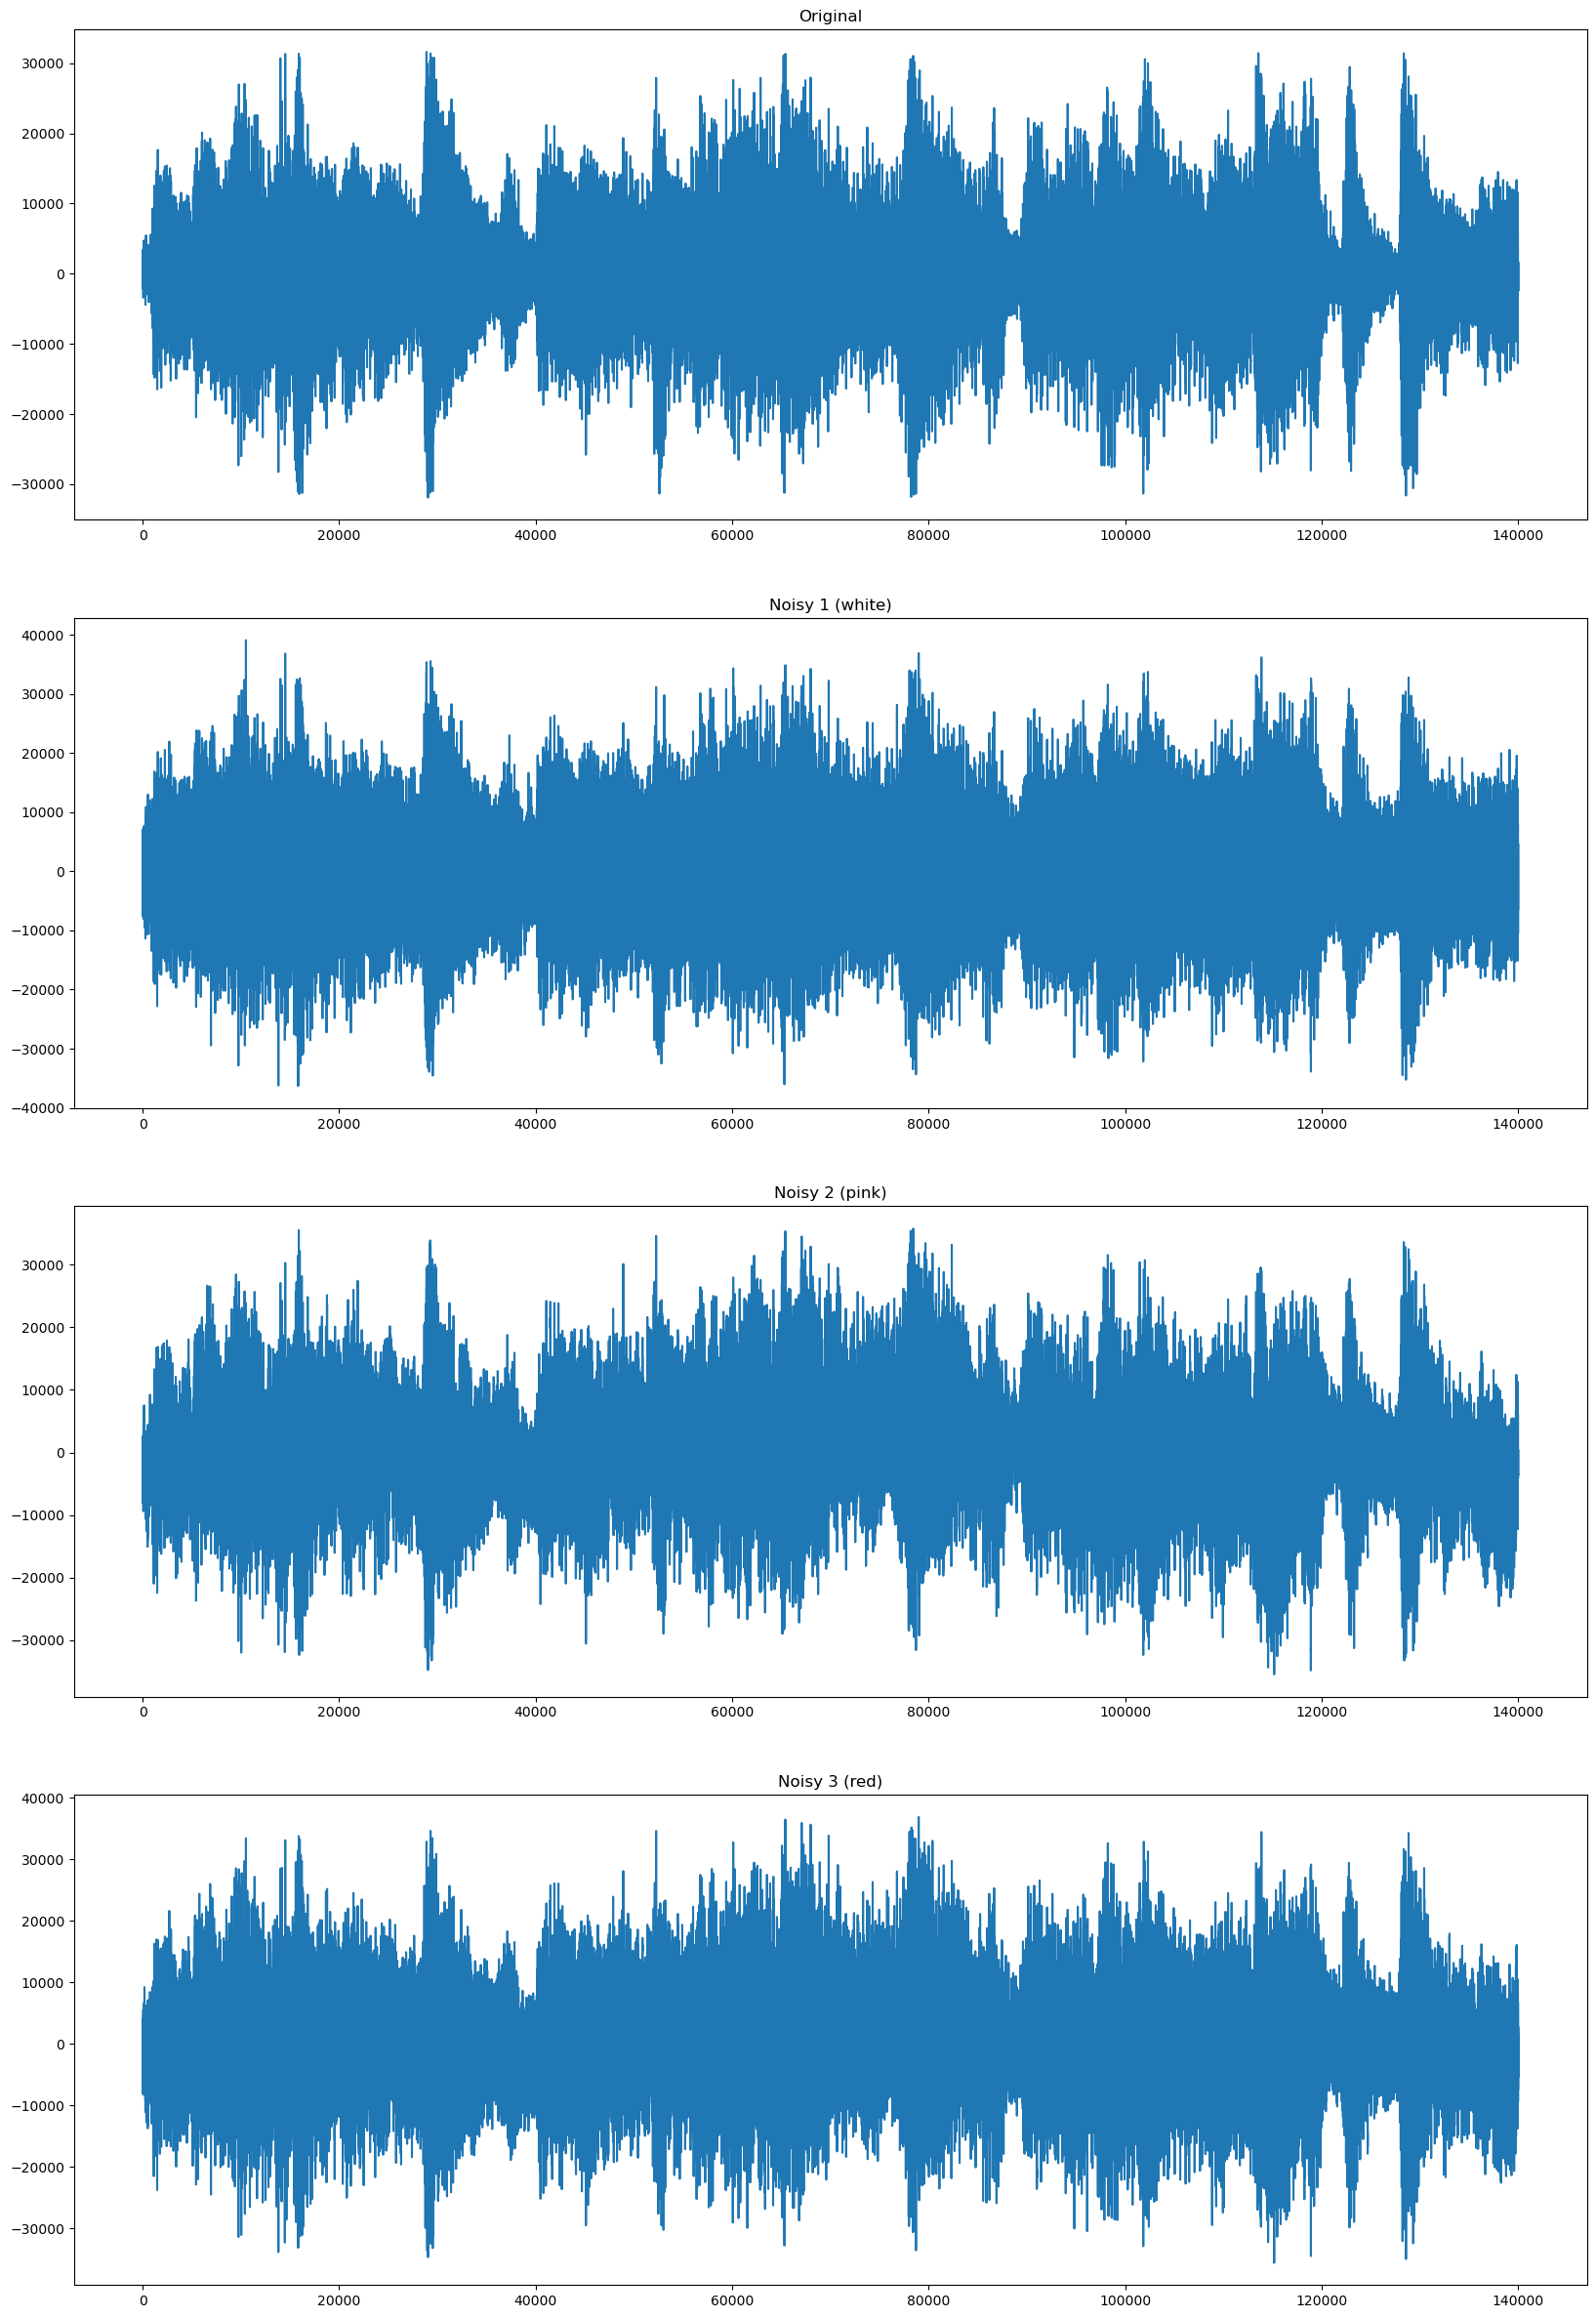

In [68]:
plt.figure(figsize=(20,30))

plt.subplot(4,1,1)
plt.plot(music)
plt.title('Original')

plt.subplot(4,1,2)
plt.plot(music_1)
plt.title('Noisy 1 (white)')

plt.subplot(4,1,3)
plt.plot(music_2)
plt.title('Noisy 2 (pink)')

plt.subplot(4,1,4)
plt.plot(music_3)
plt.title('Noisy 3 (red)')

plt.show()

We use the same formula as before, estimating the power spectrum of the original signal and that of the different noises

In [69]:
og_power = np.abs(fft(music))**2

Since we multiplied the noise with a factor before adding it to the music, we need to multiply the power spectrum with the same value but squared. We can do this because the Fourier transform is a linear operation, and obviously taking the magnitude of a complex number times a scalar is just the absolute value of the scalar times the magnitude. In equations this is:
$$
\mathcal{F\{af(t)\}}(\nu) = a\mathcal{F\{f(t)\}}(\nu) \\

| a z|^2 = a^2 |z|^2
$$

In [70]:
noise1_power = FACTOR**2*np.abs(fft(noise1))**2
noise2_power = FACTOR**2*np.abs(fft(noise2))**2
noise3_power = FACTOR**2*np.abs(fft(noise3))**2

In [71]:
filter_1 = og_power / (og_power + noise1_power)
filter_2 = og_power / (og_power + noise2_power)
filter_3 = og_power / (og_power + noise3_power)

In [72]:
denoised_1 = np.real(ifft(filter_1*fft(music_1)))
denoised_2 = np.real(ifft(filter_2*fft(music_2)))
denoised_3 = np.real(ifft(filter_3*fft(music_3)))

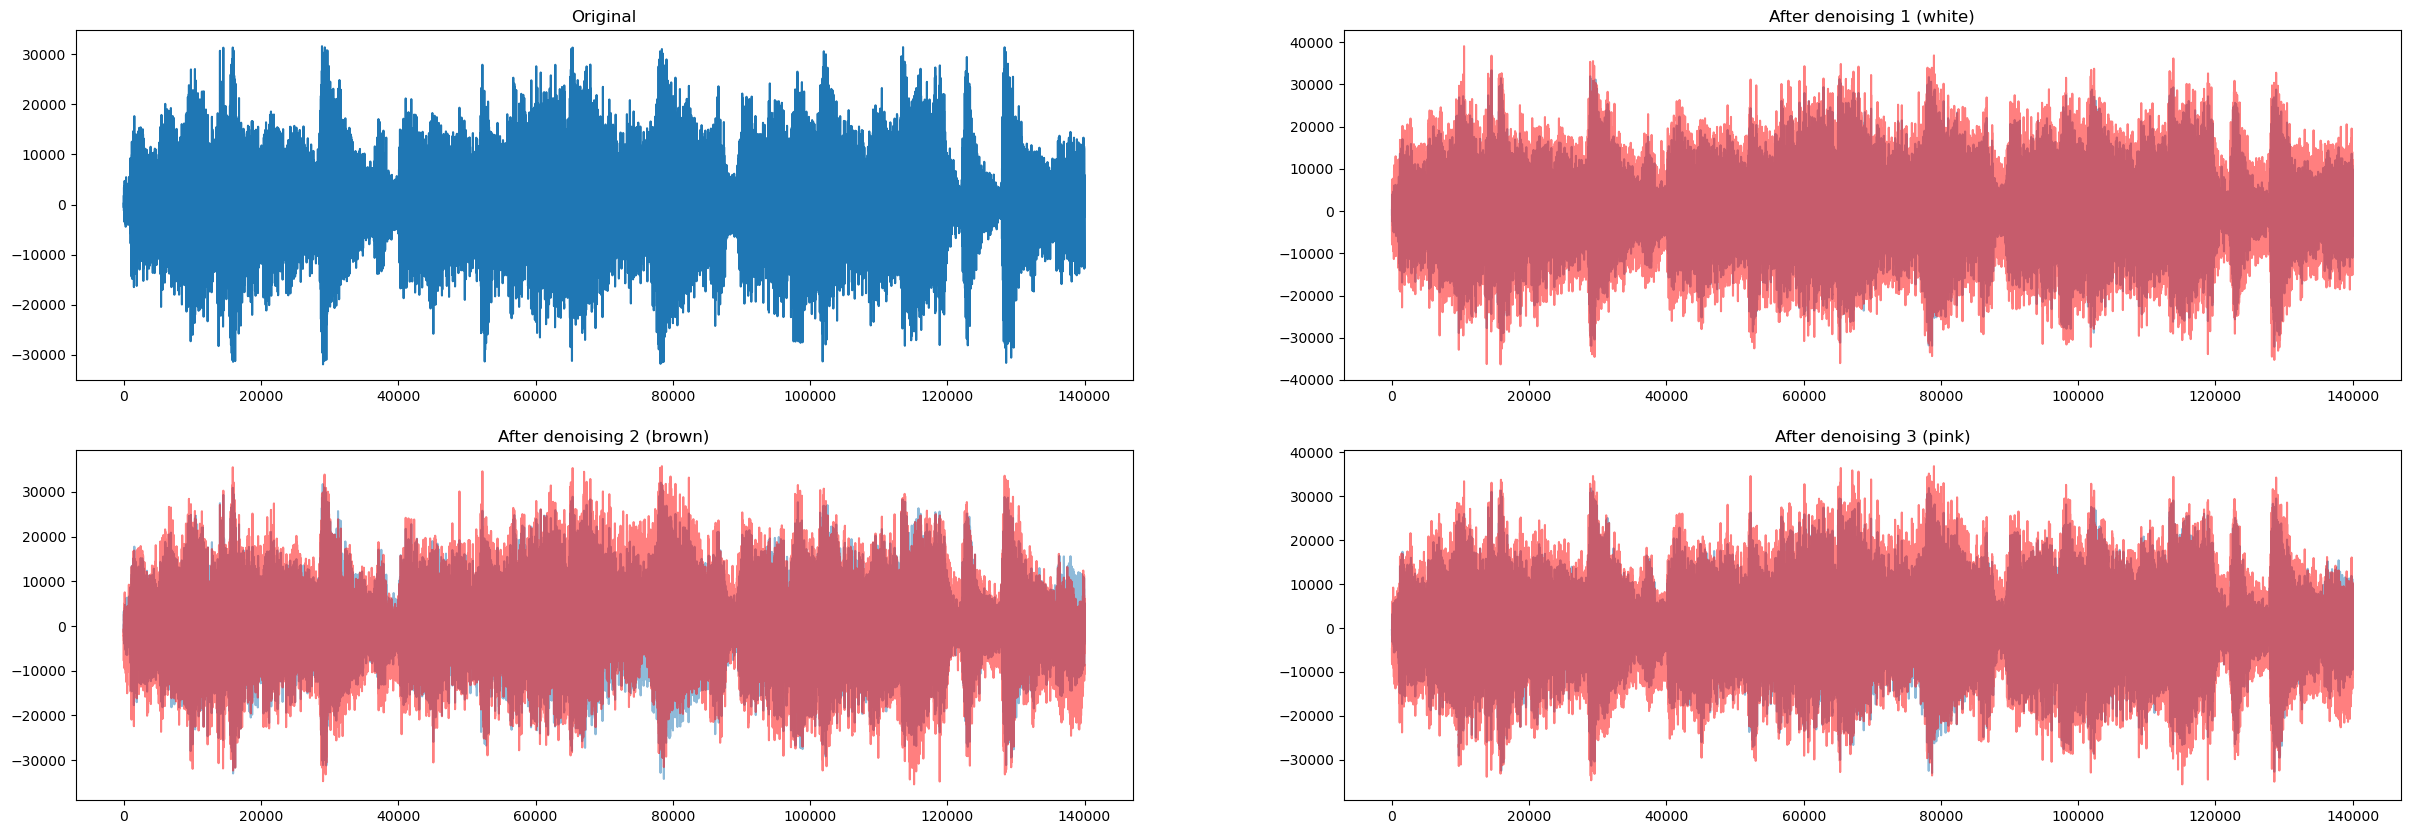

In [73]:
plt.figure(figsize=(30,10))

plt.subplot(2,2,1)
plt.plot(music)
plt.title('Original')

plt.subplot(2,2,2)
plt.plot(denoised_1, alpha=0.5)
plt.plot(music_1, alpha=0.5, color='red')
plt.title('After denoising 1 (white)')

plt.subplot(2,2,3)
plt.plot(denoised_2, alpha=0.5)
plt.plot(music_2, alpha=0.5, color='red')
plt.title('After denoising 2 (brown)')

plt.subplot(2,2,4)
plt.plot(denoised_3, alpha=0.5)
plt.plot(music_3, alpha=0.5, color='red')
plt.title('After denoising 3 (pink)')

plt.show()